# Outliers detection
Outlier detection is a technique used in data analysis to identify observations or samples that significantly differ from the rest of the dataset. An outlier is a value that deviates considerably from the general trend of the data, which can be due to measurement errors, data noise, or rare and anomalous events that do not follow the overall pattern.

Outlier detection is important because these exceptional values can have a significant impact on data analysis results and machine learning models if not handled properly. Outliers can bias descriptive statistics, affect the accuracy and interpretation of models, and lead to incorrect decisions.

In the context of clustering (data grouping), outlier detection is particularly relevant. Outliers can distort the structure of clusters, causing clustering algorithms to assign outliers to existing groups or even generate artificial clusters to accommodate outlier values. This can result in unrepresentative or less meaningful clusters.

## Libraries
Libraries to be used during code development are imported.

In [14]:
import tkinter as tk
from tkinter.filedialog import askopenfilename
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import scipy as sp

## Import Database 
In this section of the script the data to be plotted is imported. It is required that the file to work with is in a comma separated text format ".csv". Then a summary table with database statistics is generated.

In [19]:
root = tk.Tk()
root.withdraw()
database_file = askopenfilename(filetypes=[("csv files", "*.csv")])

data = pd.read_csv(database_file, na_values=[-999.25])

## Add a Sequential column to the DataFrame

In [20]:
seq = np.linspace(1, data['MD'].count(), data['MD'].count())
data.insert(0, 'Sequential', seq.tolist())

In [21]:
columnas_a_eliminar = ['MD', 'Sequential']
data.drop(columnas_a_eliminar, axis=1, inplace=True)

## Scale the data using StandardScaler

In [22]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
datascaled = pd.DataFrame(data_scaled)
datascaled.columns = data.columns

## Robust Mahalonibis Distance

### Mahalanobis Distance for Outlier Detection:

The Mahalanobis distance is a multivariate distance metric that takes into account the correlations between variables. It is particularly useful for detecting outliers in datasets with multiple features. The Mahalanobis distance measures the distance between a data point and the centroid of the dataset, considering the covariance structure of the variables.

The formula for calculating the Mahalanobis distance of a data point $\mathbf{x}$ from the mean vector $\mathbf{μ}$ with covariance matrix $\mathbf{Σ}$ is given by:

$D_{M}(\mathbf{x}) = \sqrt{(\mathbf{x} - \mathbf{μ})^\top \mathbf{Σ}^{-1} (\mathbf{x} - \mathbf{μ})}$

Here, $\mathbf{x}$ is the vector of the data point's features, $\mathbf{μ}$ is the mean vector of the dataset, and $\mathbf{Σ}$ is the covariance matrix.

To detect outliers using the Mahalanobis distance, a common approach is to compare each data point's Mahalanobis distance with a threshold value. The threshold can be determined using the Chi-square distribution, as explained below.

### Chi-square Test for Determining Threshold

The Chi-square ($\chi^2$) distribution is used to determine the threshold for outlier detection based on the degrees of freedom ($df$). The degrees of freedom in this context correspond to the number of features or variables in the dataset.

The formula for the Chi-square distribution is given by:

$\chi^2(df) = \frac{(x^2)^{\frac{df}{2}-1} e^{-\frac{x^2}{2}}}{2^{\frac{df}{2}} \Gamma\left(\frac{df}{2}\right)}$

Here, $x^2$ is the squared Mahalanobis distance, and $\Gamma(\frac{df}{2})$ is the gamma function with $\frac{df}{2}$ degrees of freedom.

To set the threshold for outlier detection, a significance level ($\alpha$) is chosen, representing the desired probability of false positives (Type I errors). For example, if $\alpha$ is set to 0.001, the threshold value $C$ is determined by:

$P(D_{M} > C) = \alpha \implies \chi^2(df) > C \implies C = \chi^2_{1-\alpha}(df)$

Where $\chi^2_{1-\alpha}(df)$ is the $(1 - \alpha)$ quantile of the Chi-square distribution with $df$ degrees of freedom.

Finally, data points with Mahalanobis distance greater than the threshold value $C$ are considered outliers.

In conclusion, the Mahalanobis distance, combined with the Chi-square test, provides an effective method for outlier detection in multivariate datasets, taking into account the covariance between variables and allowing for adaptive thresholding based on the dataset's characteristics.

In [23]:
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

## Detect outliers using the robust Mahalanobis method

In [24]:
outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=datascaled)
data['outliers'] = np.where(data.index.isin(outliers_mahal_rob), -1, 1)

## Visualize the distribution of outliers

Number of inliers: 7277
Number of outliers: 236
Total: 7513


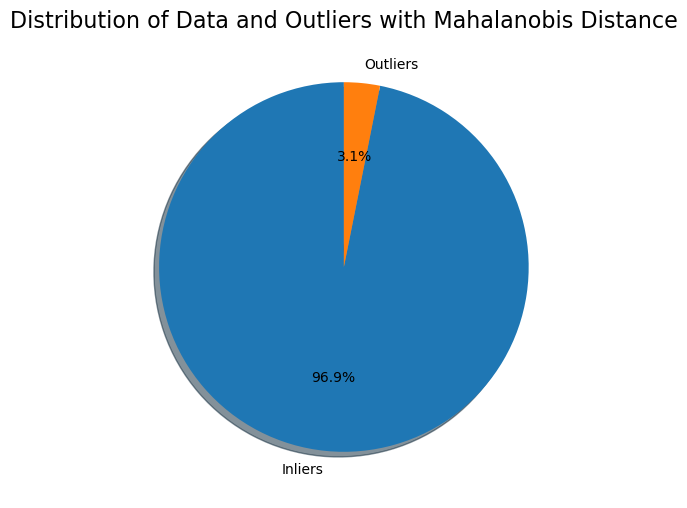

In [25]:
# Step 7: Visualize the distribution of outliers
n_inliers = (data['outliers'] == 1).sum()
n_outliers = (data['outliers'] == -1).sum()
n_total = n_inliers + n_outliers

print(f"Number of inliers: {n_inliers}")
print(f"Number of outliers: {n_outliers}")
print(f"Total: {n_total}")

labels = 'Inliers', 'Outliers'
sizes = [n_inliers, n_outliers]
plt.rcParams["figure.facecolor"] = "w"
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Distribution of Data and Outliers with Mahalanobis Distance', size=16)
plt.show()

## Create a pair plot of the data with outliers highlighted

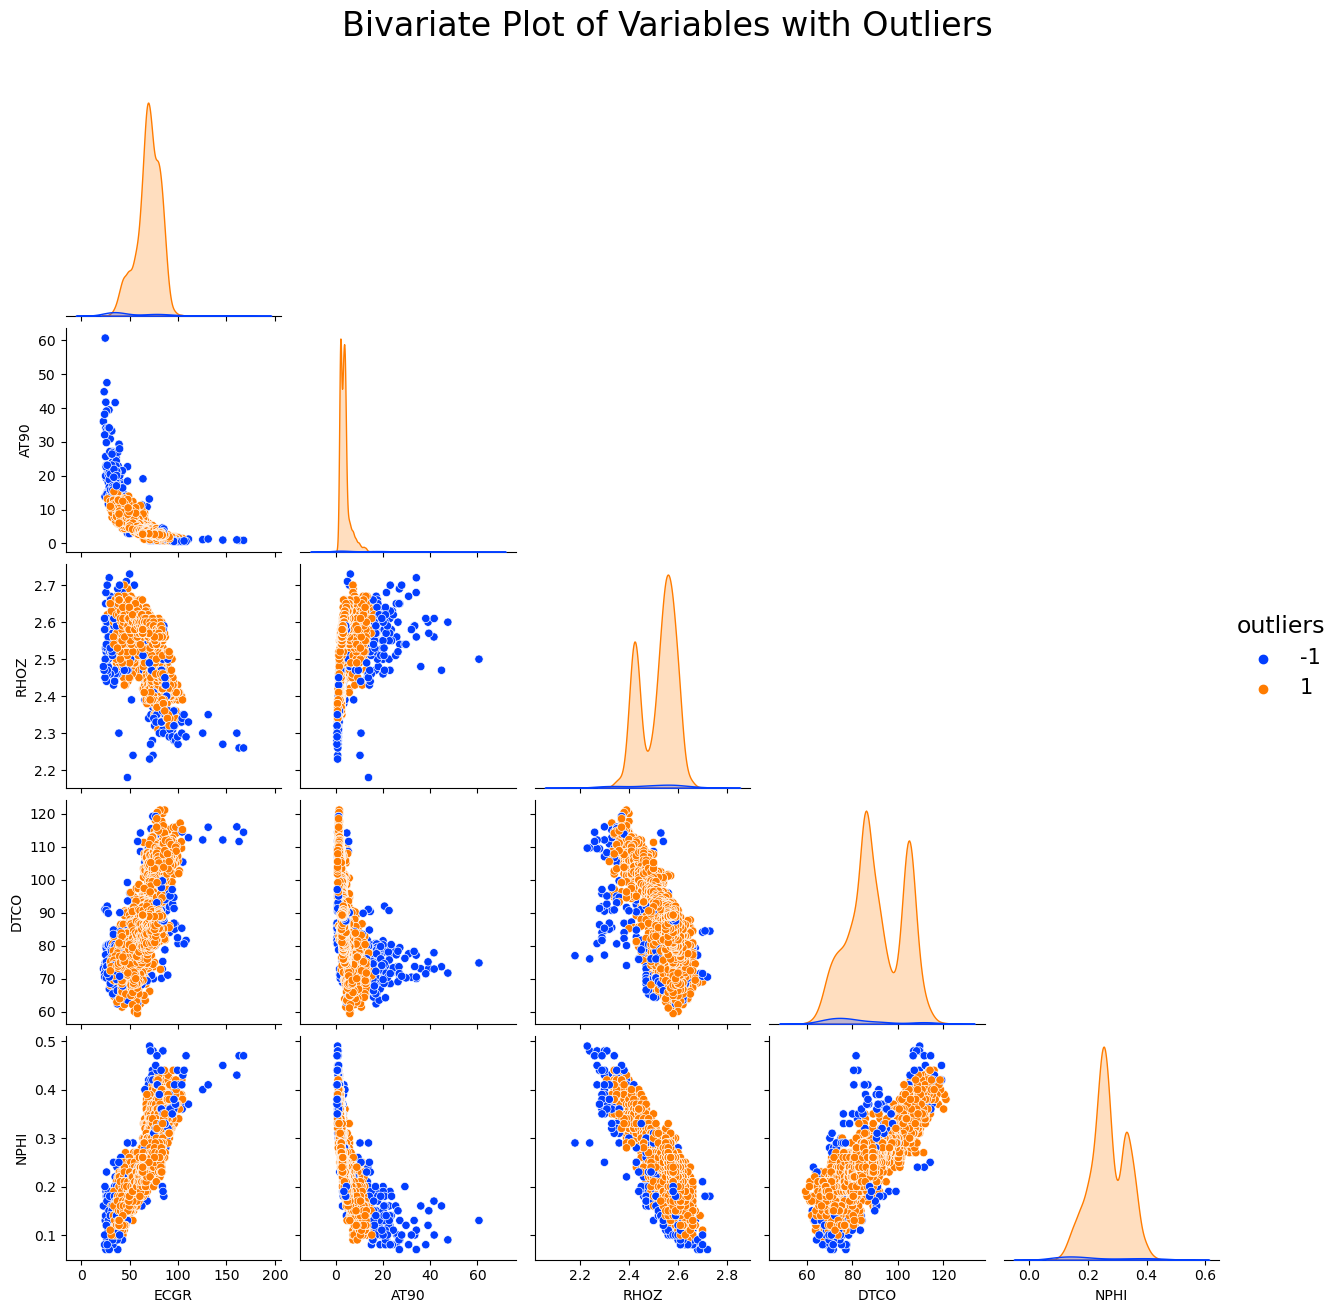

In [26]:
ds = data.copy()

plt.rc('legend', fontsize=15, title_fontsize=17)
plt.rc('axes', titlesize=25)
sns.pairplot(ds, hue='outliers', palette='bright', corner=True)
plt.suptitle('Bivariate Plot of Variables with Outliers', size=24, y=1.05)
plt.show()

## Optional: Save the DataFrame of inliers for further analysis

In [27]:
data_inliers = data[data['outliers'] == 1].drop('outliers', axis=1)

In [28]:
data_inliers.describe().apply(lambda s: s.apply('{0:.4f}'.format))

,ECGR,AT90,RHOZ,DTCO,NPHI
count,7277.0000,7277.0000,7277.0000,7277.0000,7277.0000
mean,69.2825,3.7116,2.5174,90.5540,0.2688
std,12.2316,2.0998,0.0709,12.0027,0.0616
min,27.1000,0.8000,2.3100,59.4100,0.0900
25%,62.9600,2.2000,2.4400,82.5900,0.2300
50%,70.2500,3.3200,2.5400,88.5700,0.2600
75%,78.3000,4.1800,2.5700,102.9600,0.3200
max,104.6600,16.1600,2.7000,121.1300,0.4400


In [ ]:
data_inliers.to_csv('data_inliers.csv', index=False)